In [1]:
import numpy as np
import pandas as pd
from scipy import stats,spatial,sparse
from sklearn import manifold,datasets,neighbors, decomposition
import time
import matplotlib.pyplot as plt
import seaborn as sns

import scanpy as sc
import matplotlib as mpl

In [2]:
adata = sc.datasets.paul15()
adata

  0%|          | 0.00/9.82M [00:00<?, ?B/s]

AnnData object with n_obs × n_vars = 2730 × 3451
    obs: 'paul15_clusters'
    uns: 'iroot'

In [3]:
# Select top 1000 highly-variable genes
filter_result = sc.pp.filter_genes_dispersion(adata.X,flavor='cell_ranger',n_top_genes=1000,log=False)
# Subset the genes
adata = adata[:, filter_result.gene_subset]
# Log transformation and scaling
sc.pp.log1p(adata)

C:\anaconda3\Lib\site-packages\scanpy\preprocessing\_simple.py:398: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [4]:
paul_dpt_pseudotime = pd.read_csv('./paul.dpt_pseudotime.csv',index_col=0).values.reshape(-1)
paul_palantir_time = pd.read_csv("./paul.palantir_pseudotime.csv",index_col=0).values.reshape(-1)
paul_monocle_time = pd.read_csv("./paul.monocle_pseudotime.csv",index_col=0).values.reshape(-1)
paul_dtne_time = pd.read_csv("./paul.dtne_pseudotime.csv",index_col=0).values.reshape(-1)

In [5]:
def correlation_comparation(list_A,list_B):
    # pearsonr_res = stats.pearsonr(list_A, list_B)
    spearmanr_res = stats.spearmanr(list_A, list_B) 
    tau, p_value = stats.kendalltau(list_A, list_B)
    return spearmanr_res.statistic,tau # pearsonr_res.statistic,

In [6]:
def adjacency_dist_matrix(data,k_neighbors,root_indices):
    
    n_samples = data.shape[0]
    nbrs = neighbors.NearestNeighbors(n_neighbors=k_neighbors, metric='euclidean').fit(data)
    knn_dists, knn_indices = nbrs.kneighbors(data)
        
    indptr = range(0,(n_samples+1)*k_neighbors,k_neighbors)
    k_matrix = sparse.csr_matrix((knn_dists.flatten(),knn_indices.flatten(),indptr),shape=(n_samples,n_samples))
    adjacency_matrix = k_matrix.maximum(k_matrix.T) 
    
    geo_matrix = sparse.csgraph.dijkstra(csgraph=adjacency_matrix, directed=False, indices=root_indices, return_predecessors=False)
    
    return adjacency_matrix,geo_matrix 

In [7]:
adj,geo = adjacency_dist_matrix(adata.X,20,840)

In [8]:
paul_dtne_corr = correlation_comparation(geo,paul_dtne_time)
paul_dtne_corr

(0.9267151643233882, 0.9630977434138324, 0.8265006033419371)

In [9]:
paul_dpt_corr = correlation_comparation(geo,paul_dpt_pseudotime)
paul_dpt_corr

(0.8413573057198843, 0.8779074197349331, 0.7057069443659663)

In [10]:
paul_monocle_corr = correlation_comparation(geo,paul_monocle_time)
paul_monocle_corr

(0.611709627814178, 0.7191207730186454, 0.5072048020380743)

In [11]:
paul_palantir_corr = correlation_comparation(geo,paul_palantir_time)
paul_palantir_corr

(0.8894773200265034, 0.9057150533483165, 0.7223408324910706)

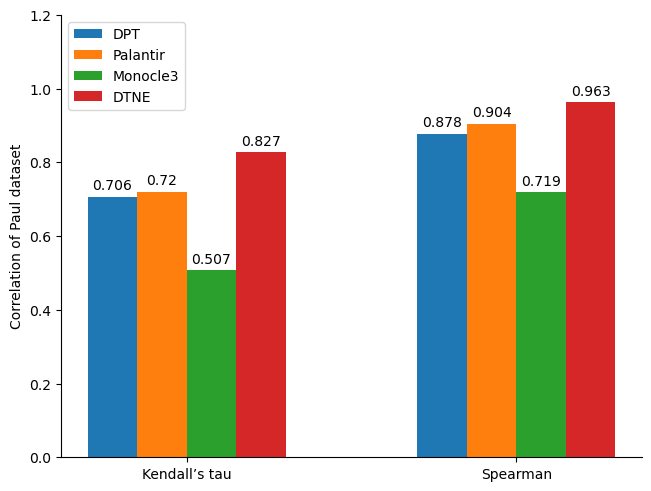

In [12]:
correlation = ['Kendall’s tau','Spearman']
pseudotime_corr = {
    'DPT':(0.706, 0.878),
    'Palantir':(0.722, 0.906),
    'Monocle3':(0.507, 0.719),
    'DTNE':(0.827, 0.963)
    }

x = np.arange(len(correlation))  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for name, corr in pseudotime_corr.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, corr, width, label=name)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_ylabel('Correlation of Paul dataset')
ax.set_xticks(x + 1.5*width, correlation)
ax.legend(loc='upper left', ncols=1)
ax.set_ylim(0, 1.2)

sns.despine(top=True,right=True,left=False,bottom=False,)
# ax.grid(False)
# ax.tick_params(bottom=True, left=True)

plt.show()

In [14]:
import matplotlib.gridspec as gridspec

In [22]:
geo = geo/max(geo)

Text(0.5, 0, 'DTNE')

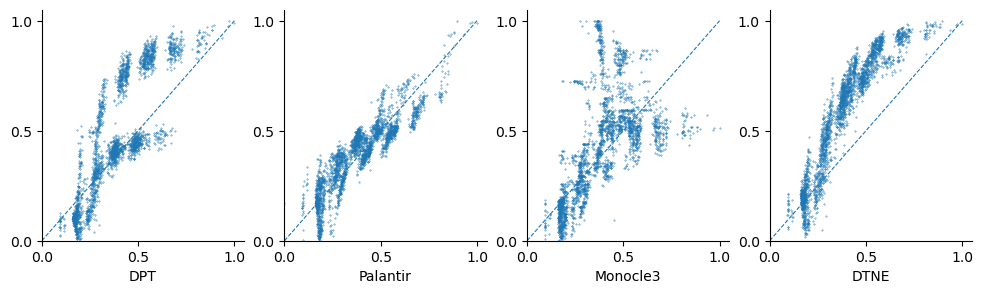

In [26]:
fig = plt.figure(figsize=(12, 3))

gs1 = gridspec.GridSpec(1, 4)
ax1 = fig.add_subplot(gs1[0])
ax2 = fig.add_subplot(gs1[1])
ax3 = fig.add_subplot(gs1[2])
ax4 = fig.add_subplot(gs1[3])

x = np.linspace(0, 1, 100)
y = x

for side in ['right','top']:
        ax1.spines[side].set_visible(False)    
ax1.plot(x, y,linestyle='--',c='tab:blue',lw=.8)
ax1.set_xlim(0, 1.05)
ax1.set_ylim(0, 1.05)
ax1.set_yticks([0,0.5,1])
ax1.scatter(geo,paul_dpt_pseudotime,s=0.1)
ax1.set_xlabel('DPT')

for side in ['right','top']:
        ax2.spines[side].set_visible(False) 
ax2.plot(x, y,linestyle='--',c='tab:blue',lw=.8)
ax2.set_xlim(0, 1.05)
ax2.set_ylim(0, 1.05)
ax2.set_yticks([0,0.5,1])
ax2.scatter(geo,paul_palantir_time,s=0.1)
ax2.set_xlabel('Palantir')

for side in ['right','top']:
        ax3.spines[side].set_visible(False) 
ax3.plot(x, y,linestyle='--',c='tab:blue',lw=.8)
ax3.set_xlim(0, 1.05)
ax3.set_ylim(0, 1.05)
ax3.set_yticks([0,0.5,1])
ax3.scatter(geo,paul_monocle_time,s=0.1)
ax3.set_xlabel('Monocle3')

for side in ['right','top']:
        ax4.spines[side].set_visible(False) 
ax4.plot(x, y,linestyle='--',c='tab:blue',lw=.8)
ax4.set_xlim(0, 1.05)
ax4.set_ylim(0, 1.05)
ax4.set_yticks([0,0.5,1])
ax4.scatter(geo,paul_dtne_time,s=0.1)
ax4.set_xlabel('DTNE')